<a href="https://colab.research.google.com/github/gamzearmagan/Image-Clasification/blob/main/Coil_100_project_Gamze_ipyn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
import torch
import matplotlib.pyplot as plt
import os, glob
import pandas as pd
from torch.utils.data import Dataset, random_split, DataLoader

In [ ]:
pip install opendatasets --upgrade

In [3]:
#username":"gamzearmaan","key":"f949707dadc9c3f5788256592e724f7b
import opendatasets as od
dataset_url = 'https://www.kaggle.com/jessicali9530/coil100'
od.download(dataset_url)

Please provide your Kaggle credentials to download this dataset. Learn more: http://bit.ly/kaggle-creds
Your Kaggle username: gamzearmaan
Your Kaggle Key: ··········


100%|██████████| 127M/127M [00:02<00:00, 60.8MB/s]


In [35]:
data_direct = './coil100/coil-100/coil-100'
file_list = glob.glob(f'{data_direct}/*.png')

labels = [(f.split('/')[-1], int(f.split('/')[-1].split('__')[0].split('obj')[1]))   for f in file_list]


In [ ]:
#checking
file_list 


In [5]:
from PIL import Image, ImageStat


#preparing data set
class Coil100_DataSet(Dataset):
  def __init__(self,label_list, root,transform=None):
    self.data_frame =label_list
    self.transform =transform
    self.root_dir =root 

  
  def __len__(self):
    return len(self.data_frame)

  def __getitem__(self, index):
    row = self.data_frame[index]
    image_id, image_label = row[0], row[1] -1
    image_name = self.root_dir + "/" + str(image_id)
    img= Image.open(image_name)
    if self.transform:
      img = self.transform(img)
    return img, image_label





In [6]:
import torchvision.transforms as transforms

dataset = Coil100_DataSet(labels, data_direct, transform=transforms.ToTensor())
len(dataset)

7200

In [ ]:
#checking
img, label = dataset[42]
print(img.shape, label)
img

In [7]:
random_seed =42
torch.manual_seed(random_seed)

In [8]:
input_channel =3 #rgb image
input_size= 3*128 *128
num_class=101

In [9]:
batch_size =100
val_size=720
test_size=720
train_size=5760

train_data, val_data, test_data =random_split(dataset,[train_size, val_size, test_size])
print(f"size of train data : {len(train_data)}")
print(f"size of train data : {len(val_data)}")

size of train data : 5760
size of train data : 720


In [10]:
train_data_load =DataLoader(train_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
val_data_load =DataLoader(val_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)
test_data_load =DataLoader(test_data, batch_size, shuffle=True, num_workers=2, pin_memory=True)

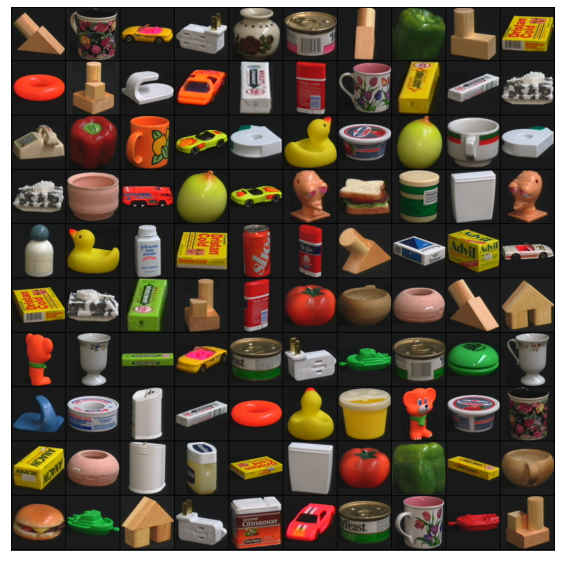

In [11]:
from torchvision.utils import make_grid
import matplotlib.pyplot as plt

def batch(dataload):
  for image, label in dataload:
    fig,ax =  plt.subplots(figsize = (10,10))
    ax.set_xticks([])
    ax.set_yticks([])
    ax.imshow(make_grid(image,nrow=10).permute(1,2,0))
    break
        
batch(train_data_load)



> CNN




In [12]:
import torch.nn as nn
import torch.nn.functional as F

In [13]:
def accuracy(outputs, labels):
    _,preds = torch.max(outputs, dim=1)
    return torch.tensor(torch.sum(preds == labels).item() / len(preds))

In [14]:

class ImageClassificationBase(nn.Module):
    
    def training_step(self, batch):
        images, labels = batch 
        out = self(images)                  # Generate predictions
        loss = F.cross_entropy(out, labels) # Calculate loss
        return loss
    
    def validation_step(self, batch):
        images, labels = batch 
        out = self(images)                    # Generate predictions
        loss = F.cross_entropy(out, labels)   # Calculate loss
        acc = accuracy(out, labels)           # Calculate accuracy
        return {'val_loss': loss.detach(), 'val_acc': acc}
        
    def validation_epoch_end(self, outputs):
        batch_losses = [x['val_loss'] for x in outputs]
        epoch_loss = torch.stack(batch_losses).mean()   # Combine losses
        batch_accs = [x['val_acc'] for x in outputs]
        epoch_acc = torch.stack(batch_accs).mean()      # Combine accuracies
        return {'val_loss': epoch_loss.item(), 'val_acc': epoch_acc.item()}
    
    def epoch_end(self, epoch, result):
        print("Epoch [{}], train_loss: {:.4f}, val_loss: {:.4f}, val_acc: {:.4f}".format(
            epoch, result['train_loss'], result['val_loss'], result['val_acc']))


In [15]:
class Coil_100_Model(ImageClassificationBase):
    def __init__(self):
        super().__init__()
        self.network = nn.Sequential(
            
            nn.Conv2d(input_channel, 32, kernel_size = 3, padding = 1),
            nn.ReLU(),
            nn.Conv2d(32,64, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(64),
        
            nn.Conv2d(64, 128, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.Conv2d(128 ,256, kernel_size = 3, stride = 1, padding = 1),
            nn.ReLU(),
            nn.MaxPool2d(2,2),
            nn.BatchNorm2d(256),
            
            
            nn.Flatten(),
            nn.Linear(256*1024,1024),
            nn.ReLU(),
            nn.Linear(1024, 512),
            nn.ReLU(),
            nn.Linear(512,num_class)
        )
    
    def forward(self, xb):
        return self.network(xb)

In [16]:
model_coil100=Coil_100_Model()
model_coil100

Coil_100_Model(
  (network): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (5): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): Conv2d(128, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU()
    (10): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (11): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (12): Flatten(start_dim=1, end_dim=-1)
    (13): Linear(in_features=262144, out_features=1024, bias=True)
    (14): ReLU()
    (15): Linear(in_features=1024, out_features=512, bias=True)
    (16): ReLU()
    (17): Linear(in_features=512, ou



> adding cpu





In [17]:
def get_default_device():
   if torch.cuda.is_available():
        return torch.device('cuda')
   else:
        return torch.device('cpu')
    
def to_device(data, device):
    if isinstance(data, (list,tuple)):
        return [to_device(x, device) for x in data]
    return data.to(device, non_blocking=True)

class DeviceDataLoader():
   def __init__(self, dl, device):
        self.dl = dl
        self.device = device
        
   def __iter__(self):
       for b in self.dl: 
            yield to_device(b, self.device)

   def __len__(self):
        return len(self.dl)

device = get_default_device()

In [18]:
train_data_load = DeviceDataLoader(train_data_load, device)
val_data_load = DeviceDataLoader(val_data_load, device)
test_data_load = DeviceDataLoader(test_data_load, device)
to_device(model_coil100, device);



> train



In [19]:
@torch.no_grad()
def evaluate(model, val_loader):
    model.eval()
    outputs = [model.validation_step(batch) for batch in val_loader]
    return model.validation_epoch_end(outputs)

  
def fit(epochs, lr, model, train_loader, val_loader, opt_func = torch.optim.SGD):
    
    history = []
    optimizer = opt_func(model.parameters(),lr)
    for epoch in range(epochs):
        
        model.train()
        train_losses = []
        for batch in train_loader:
            loss = model.training_step(batch)
            train_losses.append(loss)
            loss.backward()
            optimizer.step()
            optimizer.zero_grad()
            
        result = evaluate(model, val_loader)
        result['train_loss'] = torch.stack(train_losses).mean().item()
        model.epoch_end(epoch, result)
        history.append(result)
    
    return history




In [20]:
model_coil100 = to_device(Coil_100_Model(), device)


In [21]:
evaluate(model_coil100, val_data_load)

{'val_loss': 4.61807918548584, 'val_acc': 0.016249999403953552}

In [22]:
num_epochs = 5
opt_func = torch.optim.Adam
learning_rate=0.001

In [23]:
result = fit(num_epochs, learning_rate, model_coil100, train_data_load, val_data_load, opt_func)

Epoch [0], train_loss: 2.7100, val_loss: 1.4957, val_acc: 0.6212
Epoch [1], train_loss: 0.0779, val_loss: 0.2754, val_acc: 0.9588
Epoch [2], train_loss: 0.1245, val_loss: 0.2005, val_acc: 0.9412
Epoch [3], train_loss: 0.0852, val_loss: 0.1015, val_acc: 0.9750
Epoch [4], train_loss: 0.0448, val_loss: 0.2350, val_acc: 0.9587


In [24]:
def plot_accuracies(result):
    accuracies = [x['val_acc'] for x in result]
    plt.plot(accuracies, '-x')
    plt.xlabel('epoch')
    plt.ylabel('accuracy')
    plt.title('Accuracy vs. No. of epochs');

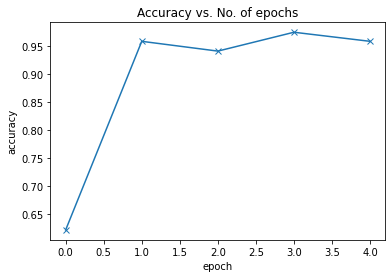

In [25]:
plot_accuracies(result)

In [26]:
def plot_losses(result):
    train_losses = [x.get('train_loss') for x in result]
    val_losses = [x['val_loss'] for x in result]
    plt.plot(train_losses, '-bx')
    plt.plot(val_losses, '-rx')
    plt.xlabel('epoch')
    plt.ylabel('loss')
    plt.legend(['Training', 'Validation'])
    plt.title('Loss vs. No. of epochs');

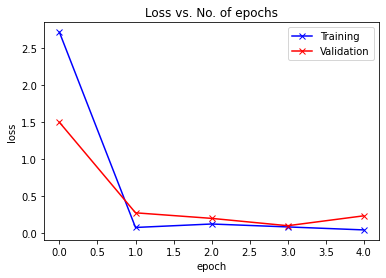

In [27]:
plot_losses(result)

In [28]:
def predict_image(img, model):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return preds[0].item()

In [ ]:
img, label = test_data[57]
plt.imshow(img.permute(1, 2, 0))
print('Label:', label, ', Predicted:', predict_image(img, model_coil100))

GUI

In [ ]:
!pip install -q gradio torch torchvision

In [31]:
import gradio
import gradio as gr

In [40]:
def classify_image(inp):
    img = inp.reshape((-1,224,224,3)) #reshape input image
    prediction = model_coil100.predict(img).flatten() #prediction
    #return classes
    return {labels[i]: float(prediction[i]) for i in range(100)}

image = gr.inputs.Image(shape=(224, 224))
label = gr.outputs.Label(num_top_classes=1)

gui=gr.Interface(fn=classify_image, inputs=image, outputs=label, capture_session=True).launch(debug=True,share=True)
gui.launch()


/usr/local/lib/python3.8/dist-packages/gradio/inputs.py:257: UserWarning: Usage of gradio.inputs is deprecated, and will not be supported in the future, please import your component from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `optional` parameter is deprecated, and it has no effect
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/outputs.py:197: UserWarning: Usage of gradio.outputs is deprecated, and will not be supported in the future, please import your components from gradio.components
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: The 'type' parameter has been deprecated. Use the Number component instead.
  warnings.warn(value)
/usr/local/lib/python3.8/dist-packages/gradio/deprecation.py:40: UserWarning: `capture_session` parameter is deprecated, and it has no effect
  warnings.warn(value)


Colab notebook detected. This cell will run indefinitely so that you can see errors and logs. To turn off, set debug=False in launch().
Running on public URL: https://8b9ef937-16e1-4315.gradio.live

This share link expires in 72 hours. For free permanent hosting and GPU upgrades (NEW!), check out Spaces: https://huggingface.co/spaces


Keyboard interruption in main thread... closing server.
Killing tunnel 127.0.0.1:7862 <> https://8b9ef937-16e1-4315.gradio.live


AttributeError: ignored